In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from qcl.testing.OneDimDataset import prepare_dataset,eval

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

from qcl.regressors.StandardQCLRegressor import StandardQCLRegressor
from qcl.gates.CNOTRotationGates import CNOTRotationGates
from qcl.Encoders.XYEncoder import XYEncoder
from qcl.Encoders.prerocess import *
from qcl.gates.Observable import ZObservable
from qcl.testing.DNNModel import DNNModel

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel,RBF


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


2022-08-22 10:31:30.136748: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/g16//g16/bsd:/opt/g16//g16:/opt/mopac:/opt/g16//gv/lib
2022-08-22 10:31:30.136813: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [43]:

from sklearn.metrics import mean_squared_error
def eval_model(model,tr_X,tr_y,te_inner_X,te_inner_y,te_low_X,te_low_y,te_high_X,te_high_y):

    model.fit(tr_X,tr_y)

    #extrapolating regions
    out_X=[]
    out_X.append(te_high_X)
    out_X=np.array(out_X).reshape(-1,1)

    out_y=[]
    out_y.append(te_high_y)
    out_y=np.array(out_y).reshape(-1)

    out_pred_y=model.predict(out_X)
    out_error=mean_squared_error(out_pred_y,out_y)

    return out_error

loss 0.000001444203174
1/1 [==============================] - 0s 10ms/step
loss 0.000001056975349
1/1 [==============================] - 0s 10ms/step
loss 0.000000649430493
2/2 [==============================] - 0s 906us/step
loss 0.000000630119215
3/3 [==============================] - 0s 671us/step
loss 0.000000348780562
3/3 [==============================] - 0s 717us/step
loss 0.000000147660691
1/1 [==============================] - 0s 11ms/step
loss 0.000000130518653
1/1 [==============================] - 0s 11ms/step
loss 0.000000088194555
2/2 [==============================] - 0s 891us/step
loss 0.000000095296099
3/3 [==============================] - 0s 673us/step
loss 0.000000011399263
3/3 [==============================] - 0s 759us/step
loss 0.000001850589364
1/1 [==============================] - 0s 10ms/step
loss 0.000000677122999
1/1 [==============================] - 0s 10ms/step
loss 0.000000317903272
2/2 [==============================] - 0s 959us/step
loss 0.00000018851

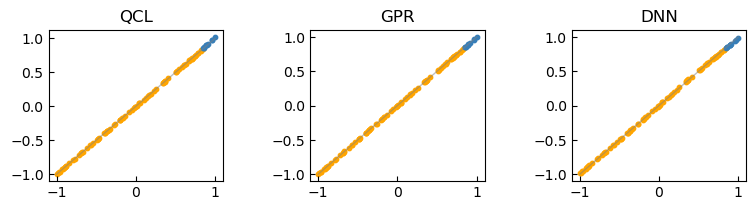

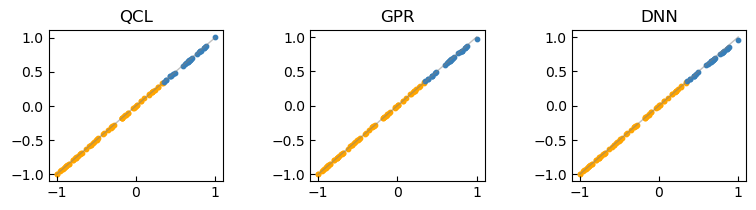

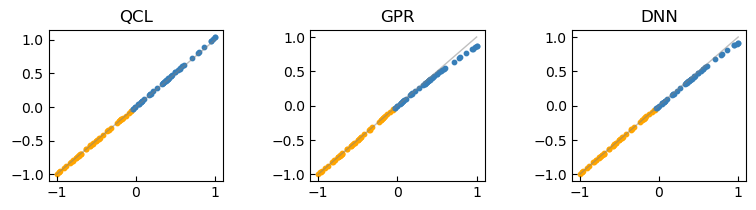

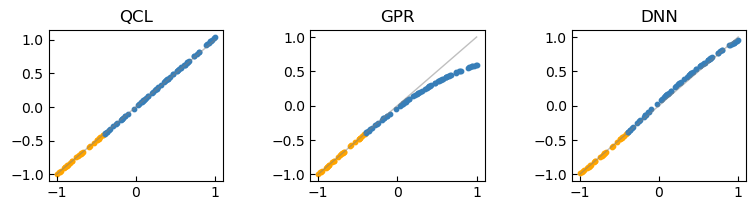

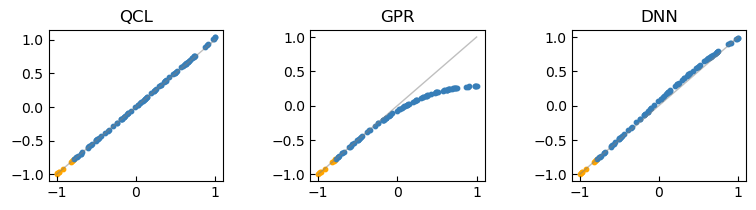

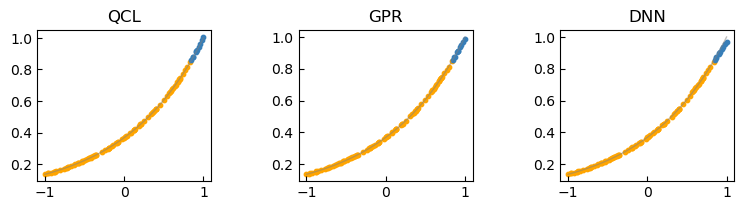

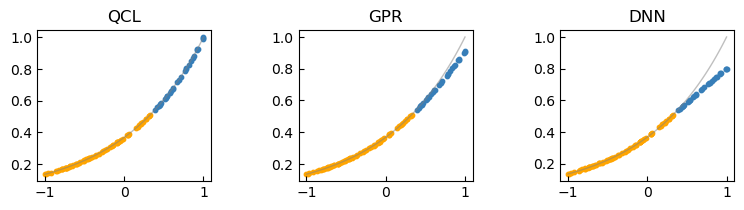

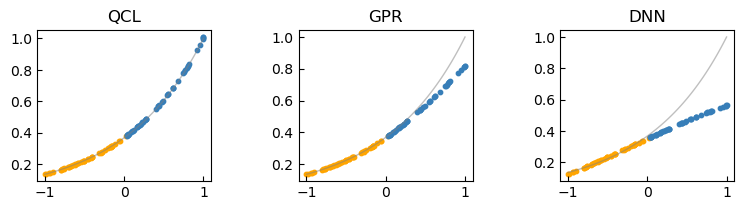

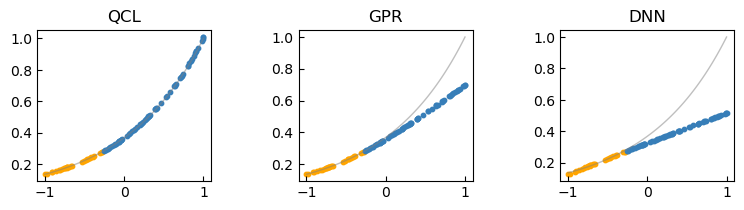

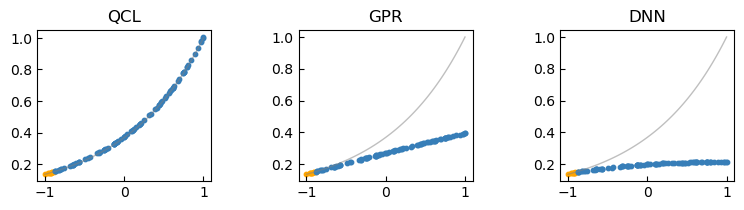

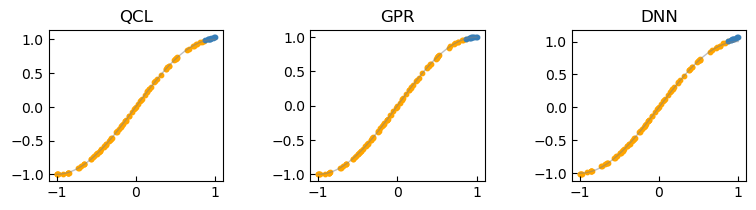

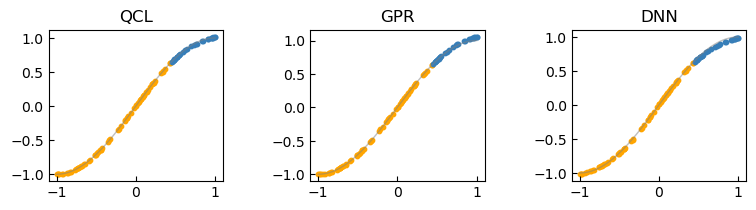

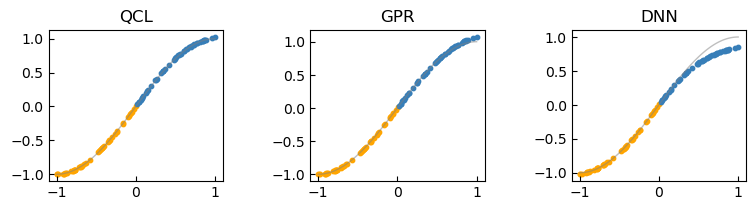

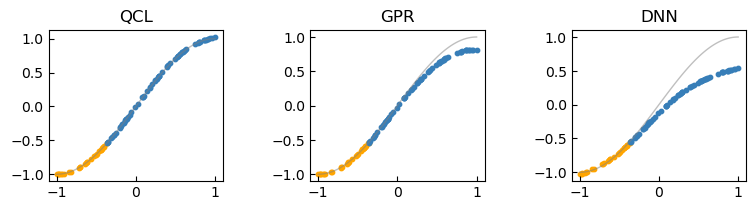

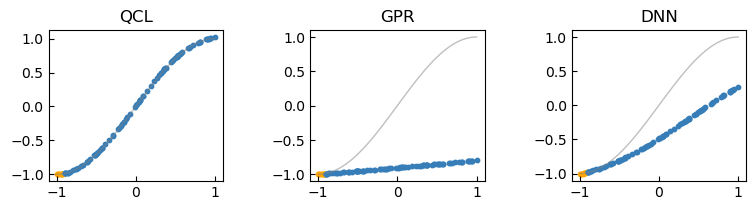

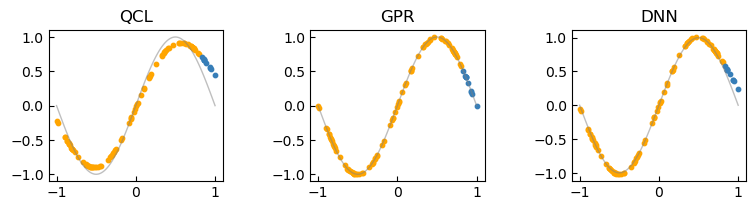

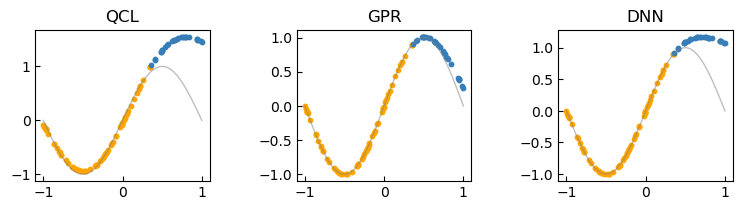

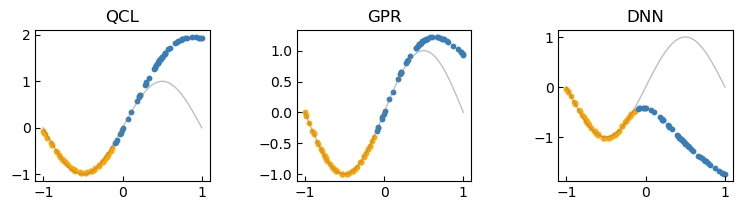

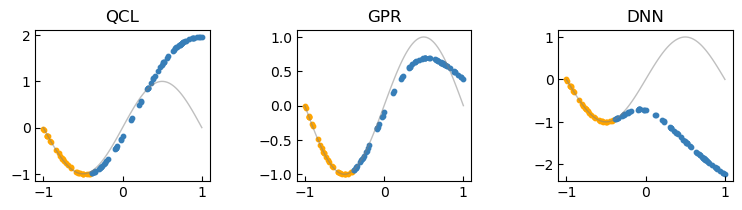

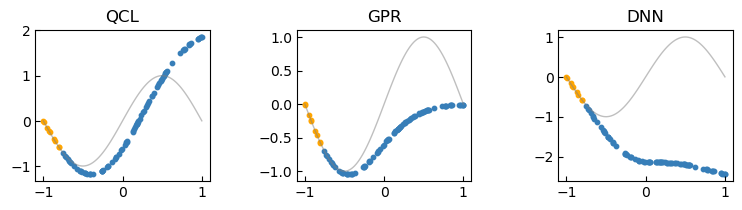

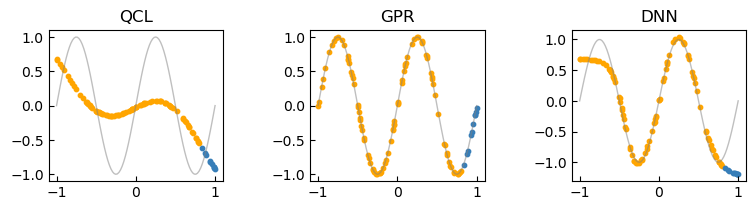

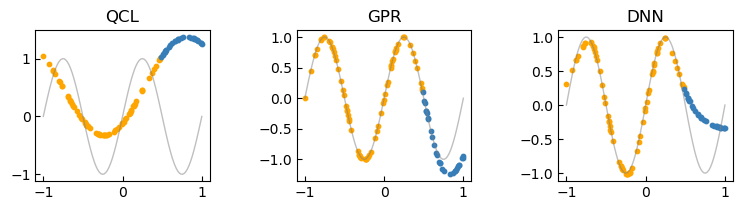

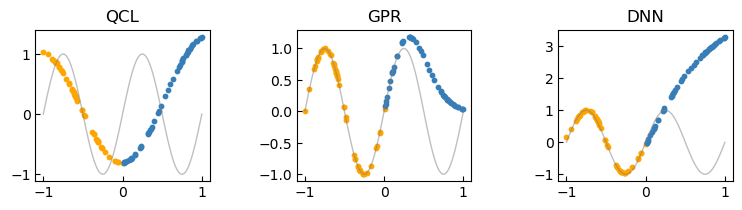

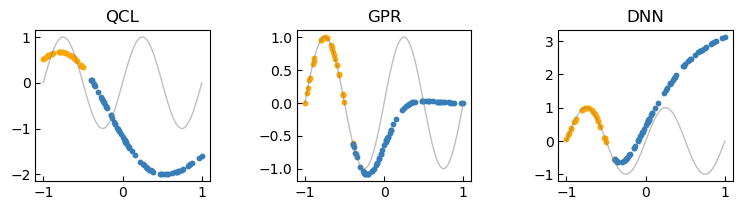

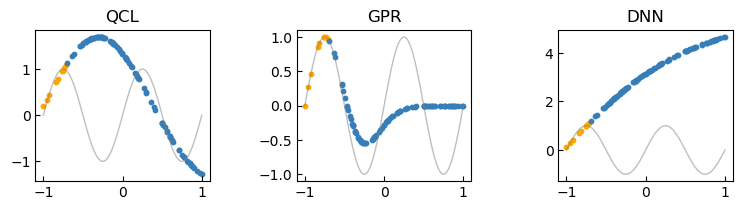

In [55]:
import warnings
warnings.simplefilter('ignore')

x_dim=1
n_qubit=2
depth=3
model_dict={}
model_dict["QCL"]=StandardQCLRegressor(x_dim=x_dim,n_qubit=n_qubit,encoder=XYEncoder(n_qubit),observable=ZObservable(n_qubit=n_qubit,coeff=2),vqe_gates=CNOTRotationGates(n_qubit=n_qubit,depth=depth))
#model_dict["SVR"]=SVR()
#model_dict["RFR"]=RandomForestRegressor()
#model_dict["BYR"]=BayesianRidge()
model_dict["GPR"]=GaussianProcessRegressor(kernel=WhiteKernel()+RBF())
model_dict["DNN"]=DNNModel(hidden_dim=8,layers=1,activation="tanh")


res_dict={}
count=0

for n in range(30):
    for mode in ["linear","exp","sin1/2","sin","sin2"]:
    #for mode in ["sin1/2","sin","sin2","linear","exp"]:
        for extra_high_ratio in [0.1,0.3,0.5,0.7,0.9]:
            tr_X,tr_y,te_inner_X,te_inner_y,te_low_X,te_low_y,te_high_X,te_high_y,act_X,act_y=prepare_dataset(
                n_all_record=100,
                mode=mode,
                plot=False,
                extra_high_ratio=extra_high_ratio,
                extra_low_ratio=0.0,
                inner_test_ratio=0.0)

            i=0

            if n==0:
                fig = plt.figure(figsize=(9,2),dpi=100)
            for model_name,model in model_dict.items():

                model.fit(tr_X,tr_y)
                out_pred_y=model.predict(te_high_X)
                out_error=mean_squared_error(out_pred_y,te_high_y)

                if n==0:
                    plt.subplots_adjust(wspace=0.5, hspace=0.6)
                    ax = fig.add_subplot(1, len(list(model_dict.keys())), i+1)
                    plot=True
                else:
                    plot=False
                eval(ax,model,tr_X,tr_y,te_inner_X,te_inner_y,te_low_X,te_low_y,te_high_X,te_high_y,act_X,act_y,title=model_name,plot=plot)
                i+=1

                temp_dict={}
                temp_dict["Model"]=model_name
                temp_dict["Extra"]=out_error
                temp_dict["Mode"]=mode
                temp_dict["Extra ratio"]=extra_high_ratio

                res_dict[count]=temp_dict
                count+=1


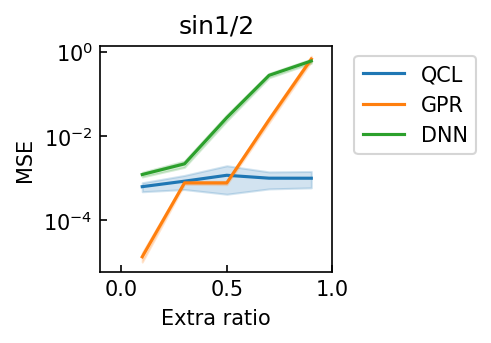

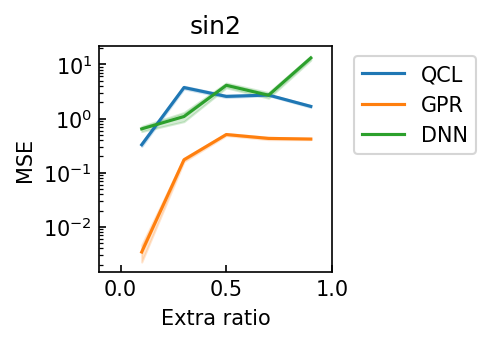

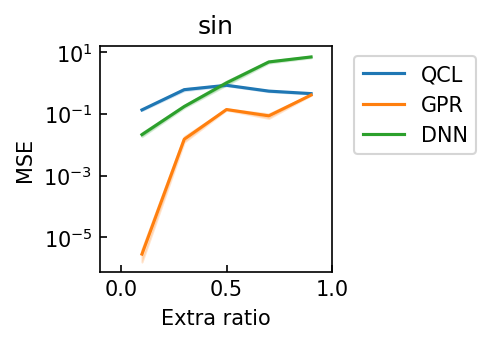

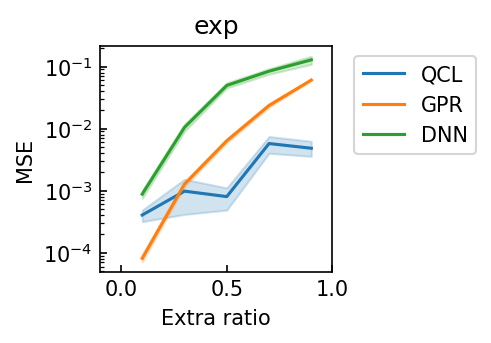

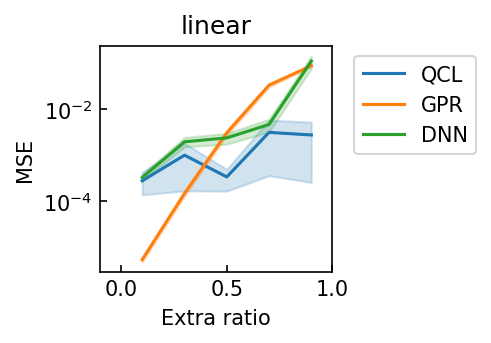

In [56]:

import pandas as pd
import seaborn as sns

df=pd.DataFrame.from_dict(res_dict).T

for mode in set(df["Mode"]):

    plt.figure(figsize=(2,2),dpi=150)

    ax=sns.lineplot(data=df[df["Mode"]==mode],y="Extra",x="Extra ratio",hue="Model",ci=68)
    ax.set_xlim(-0.1,1)
    ax.set_title(mode)
    ax.set_ylabel("MSE")
    ax.set(yscale="log")
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

    """
    plt.figure(figsize=(4,6),dpi=150)
    ax=sns.swarmplot(data=df,y="Model",x="Inner",hue="Mode",alpha=0.8,size=2)
    ax.set_xlim(-0.1,1)
    #ax.set(xscale="log")
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    """




In [58]:
#df.to_csv("res/1d_extra.csv")
df

,Model,Extra,Mode,Extra ratio
0,QCL,0.000126,linear,0.1
1,GPR,0.000003,linear,0.1
2,DNN,0.000181,linear,0.1
3,QCL,0.000054,linear,0.3
4,GPR,0.00011,linear,0.3
...,...,...,...,...
2245,GPR,0.497013,sin2,0.7
2246,DNN,1.840726,sin2,0.7
2247,QCL,1.039169,sin2,0.9
2248,GPR,0.432595,sin2,0.9
